In [55]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from typing import List, Tuple, Iterable, Any, Callable
from collections import Counter, defaultdict
from datetime import datetime

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [56]:
def get_freq_table(counter: Counter, max: int = 9) -> pd.DataFrame:
    table = []
    other = {"Type": "Other", "Count": 0, "Percentage": 0}
    total = sum(counter.values())
    for key, value in sorted(counter.items(), key=lambda x: x[1], reverse=True):
        if len(table) < max:
            table.append(
                {
                    "Type": key,
                    "Count": value,
                    "Percentage": f"{100 * value / total:.2f}%",
                }
            )
        else:
            other["Count"] += value
    if other["Count"] != 0:
        other["Percentage"] = f"{100 * other['Count'] / total:.2f}%"
        table.append(other)
    return pd.DataFrame(table)

In [57]:
def plot_yearly_freq(
    ax: plt.Axes,
    series: Iterable[Tuple[datetime, Any]],
    percentage: bool = False,
    max: int = 9,
    order: Callable = lambda x: -x[1],
    palette: str = "Set2"
):
    yearly_counter = defaultdict(Counter)
    all_values = Counter()

    for date, value in series:
        yearly_counter[date.year][value] += 1
        all_values[value] += 1

    if len(all_values) > max:
        temp = Counter({k: v for k, v in all_values.most_common(max)})
        temp["Other"] = sum(all_values.values()) - sum(temp.values())
        all_values = temp
        for year, counter in yearly_counter.items():
            temp = Counter({k: counter[k] for k in all_values})
            temp["Other"] = sum(counter.values()) - sum(temp.values())
            yearly_counter[year] = temp

    if percentage:
        for year, counter in yearly_counter.items():
            yearly_counter[year] = Counter(
                {k: 100 * v / sum(counter.values()) for k, v in counter.items()}
            )

    years = sorted(yearly_counter.keys())
    counts = {}
    for k, _ in sorted(all_values.items(), key=order):
        counts[k] = [yearly_counter[year][k] for year in years]

    colors = sns.color_palette(palette, len(counts))
    bottom = np.zeros(len(years))
    i = 0
    for label, count in counts.items():
        ax.bar(years, count, width=0.8, label=label, bottom=bottom, color=colors[i])
        i += 1
        bottom += count

    if percentage:
        ax.set_ylim(0, 103)
        ax.set_yticks([0, 20, 40, 60, 80, 100])
        ax.set_yticklabels(["0%", "20%", "40%", "60%", "80%", "100%"])
    ax.set_xlim(years[0] - 0.7, years[-1] + 0.7)
    ax.tick_params(axis="y", labelsize=12)
    ax.tick_params(axis="x", labelsize=12)
    ax.set_xticks(range(years[0], years[-1] + 1, 2))
    ax.legend(loc="upper left")


TOP 5000:

In [58]:
data_top = pd.read_csv("data/license_changes.csv")
data_top["date"] = pd.to_datetime(data_top.date)
print(f"{len(set(data_top.package))} packages with >= 1 known license")
data_top.head()

4672 packages with >= 1 known license


,package,version,date,license,license_type
0,flask-mongoengine,0.1,2012-05-17 16:21:38.866000+00:00,BSD-3-Clause,Permissive
1,plotly-resampler,0.7.2.2,2022-06-29 16:21:57.914000+00:00,MIT,Permissive
2,google-cloud-functions,0.4.0,2020-10-02 18:06:54.738000+00:00,Apache-2.0,Permissive
3,check-jsonschema,0.2.0,2021-01-08 05:59:41.547000+00:00,Apache-2.0,Permissive
4,jcloud,0.0.0,2022-04-11 09:39:02.489000+00:00,Apache-2.0,Permissive


In [59]:
get_freq_table(Counter(map(
    lambda x: f"{x - 1} Known License Changes", 
    Counter(data_top.package).values()
)))

,Type,Count,Percentage
0,0 Known License Changes,4160,89.04%
1,1 Known License Changes,425,9.10%
2,2 Known License Changes,55,1.18%
3,3 Known License Changes,21,0.45%
4,5 Known License Changes,4,0.09%
5,4 Known License Changes,4,0.09%
6,6 Known License Changes,2,0.04%
7,7 Known License Changes,1,0.02%


In [60]:
license_changes: List[Tuple[datetime, str]] = []
for pkg, df in data_top.groupby("package"):
    if len(df) == 1:
        continue
    for l1, l2, t in zip(df.license, df.license[1:], df.date[1:]):
        license_changes.append((t, l1 + " -> " + l2))
get_freq_table(Counter(c[1] for c in license_changes), max=20)

,Type,Count,Percentage
0,Apache-2.0 -> MIT,62,9.49%
1,BSD-3-Clause -> MIT,60,9.19%
2,MIT -> Apache-2.0,56,8.58%
3,BSD-3-Clause -> Apache-2.0,34,5.21%
4,GPL-3.0-only -> MIT,28,4.29%
5,MIT -> BSD-3-Clause,22,3.37%
6,Apache-2.0 -> BSD-3-Clause,20,3.06%
7,GPL-3.0-only -> BSD-3-Clause,14,2.14%
8,LGPL-3.0-only -> MIT,14,2.14%
9,GPL-3.0-only -> Apache-2.0,13,1.99%


In [61]:
license_type_changes: List[Tuple[datetime, str]] = []
license_perm_changes: List[Tuple[datetime, str]]= []
perm = {"Permissive": 0, "Weak Copyleft": 1, "Strong Copyleft": 2}
for pkg, df in data_top[data_top.license_type != "Unknown"].groupby("package"):
    if len(df) == 1:
        continue
    for l1, l2, t in zip(df.license_type, df.license_type[1:], df.date[1:]):
        license_type_changes.append((t, l1 + " -> " + l2))
        if perm[l1] == perm[l2]:
            license_perm_changes.append((t, "Same"))
        elif perm[l1] > perm[l2]:
            license_perm_changes.append((t, "More Permissive"))
        else:
            license_perm_changes.append((t, "Less Permissive"))
get_freq_table(Counter(x[1] for x in license_type_changes))

,Type,Count,Percentage
0,Permissive -> Permissive,315,53.12%
1,Strong Copyleft -> Permissive,91,15.35%
2,Weak Copyleft -> Permissive,44,7.42%
3,Strong Copyleft -> Strong Copyleft,35,5.90%
4,Strong Copyleft -> Weak Copyleft,29,4.89%
5,Weak Copyleft -> Weak Copyleft,28,4.72%
6,Permissive -> Strong Copyleft,26,4.38%
7,Permissive -> Weak Copyleft,18,3.04%
8,Weak Copyleft -> Strong Copyleft,7,1.18%


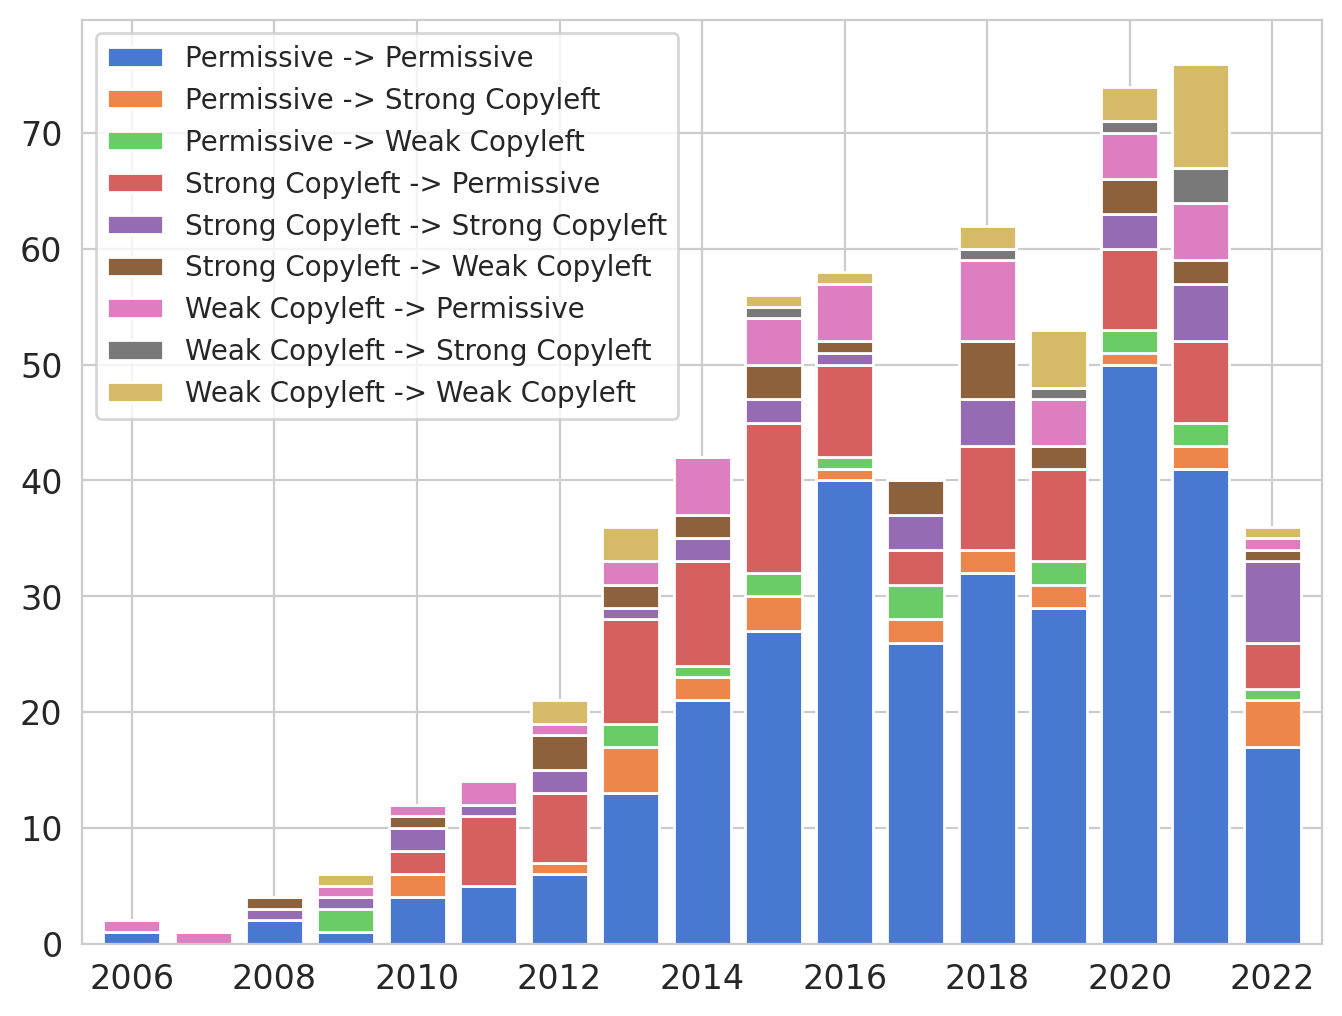

In [62]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(8, 6))
    plot_yearly_freq(ax, license_type_changes, order=lambda x: x[0], palette="muted")
    # fig.autofmt_xdate()

In [63]:
get_freq_table(Counter(x[1] for x in license_perm_changes))

,Type,Count,Percentage
0,Same,378,63.74%
1,More Permissive,164,27.66%
2,Less Permissive,51,8.60%


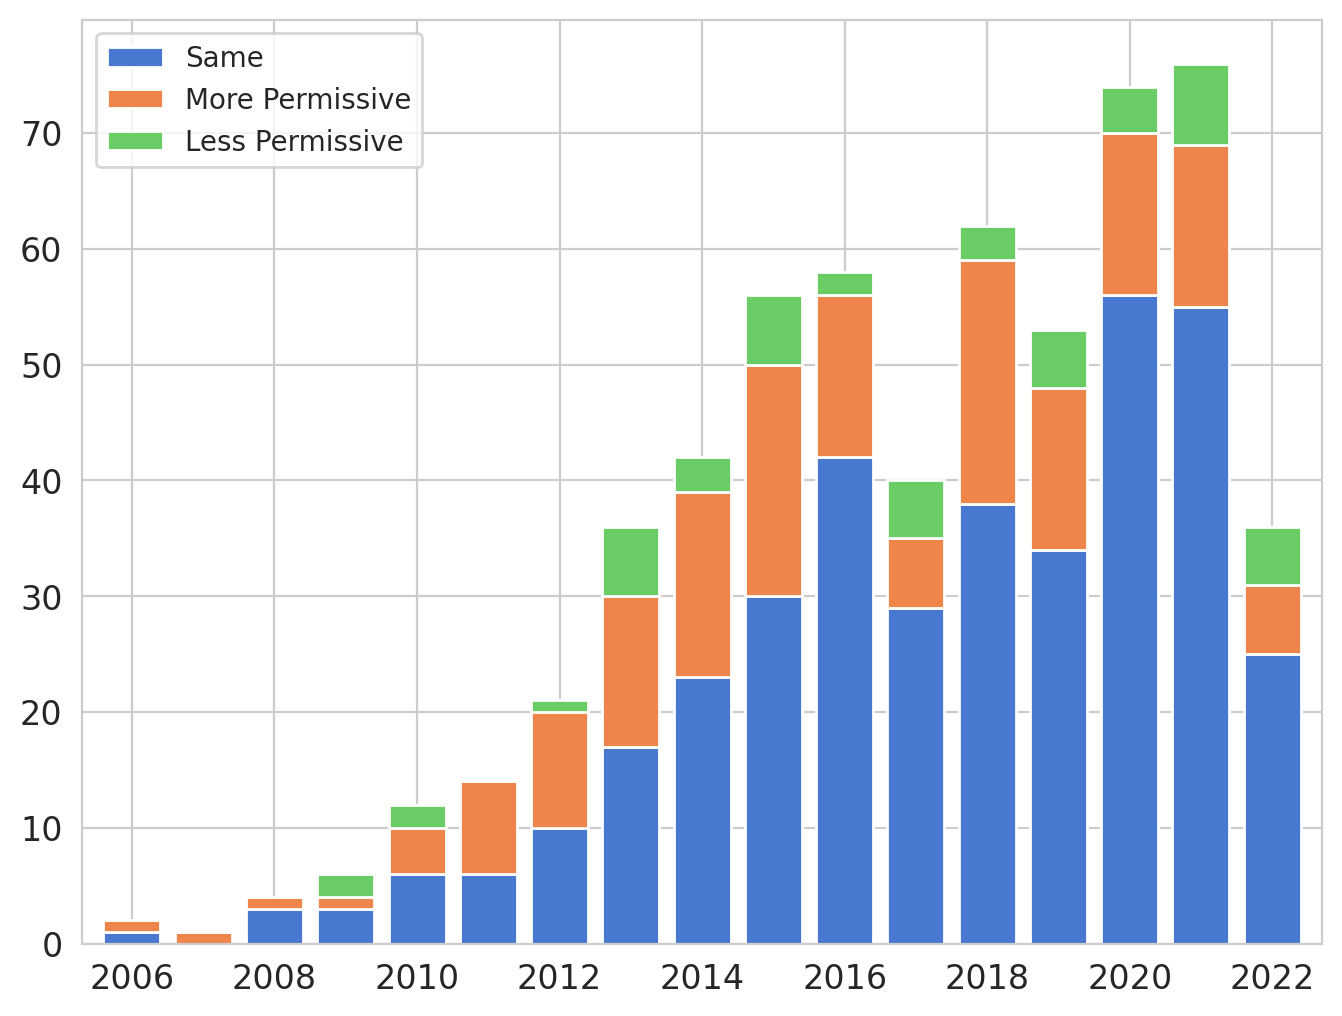

In [64]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(8, 6))
    plot_yearly_freq(ax, license_perm_changes, palette="muted")
    # fig.autofmt_xdate()

entire pypi:

In [65]:
data_pypi = pd.read_csv("data/license_changes_pypi.csv")
data_pypi["date"] = pd.to_datetime(data_pypi.date)
print(f"{len(set(data_pypi.package))} packages with >= 1 known license")
data_pypi.head()

332746 packages with >= 1 known license


,package,version,date,license,license_type
0,zzzzztest2000,1.24.58,2022-08-23 19:43:43.200000+00:00,Apache-2.0,Permissive
1,zzzzztest2,1.24.58,2022-08-23 19:10:49.476000+00:00,Apache-2.0,Permissive
2,zzzzls-spider,1.2.3,2020-11-19 05:46:56.317000+00:00,MIT,Permissive
3,zzzzls-spider,1.2.5,2020-11-19 06:44:52.617000+00:00,Apache-2.0,Permissive
4,zzzymobbe,1.0,2022-07-06 01:51:32.861000+00:00,GPL-3.0-only,Strong Copyleft


In [66]:
get_freq_table(Counter(map(
    lambda x: f"{x - 1} Known License Changes", 
    Counter(data_pypi.package).values()
)))

,Type,Count,Percentage
0,0 Known License Changes,322629,96.96%
1,1 Known License Changes,8983,2.70%
2,2 Known License Changes,855,0.26%
3,3 Known License Changes,198,0.06%
4,4 Known License Changes,44,0.01%
5,5 Known License Changes,20,0.01%
6,6 Known License Changes,8,0.00%
7,7 Known License Changes,3,0.00%
8,8 Known License Changes,2,0.00%
9,Other,4,0.00%


In [67]:
license_changes: List[Tuple[datetime, str]] = []
for pkg, df in data_pypi.groupby("package"):
    if len(df) == 1:
        continue
    for l1, l2, t in zip(df.license, df.license[1:], df.date[1:]):
        license_changes.append((t, l1 + " -> " + l2))
get_freq_table(Counter(c[1] for c in license_changes), max=20)

,Type,Count,Percentage
0,MIT -> Apache-2.0,1070,9.15%
1,BSD-3-Clause -> MIT,820,7.01%
2,MIT -> BSD-3-Clause,693,5.92%
3,Apache-2.0 -> MIT,686,5.86%
4,GPL-3.0-only -> MIT,677,5.79%
5,MIT -> GPL-3.0-only,659,5.63%
6,GPL-3.0-only -> GPL-3.0-or-later,556,4.75%
7,GPL-3.0-only -> BSD-3-Clause,341,2.91%
8,BSD-3-Clause -> Apache-2.0,248,2.12%
9,GPL-3.0-only -> Apache-2.0,223,1.91%


In [68]:
license_type_changes: List[Tuple[datetime, str]] = []
license_perm_changes: List[Tuple[datetime, str]]= []
perm = {"Permissive": 0, "Weak Copyleft": 1, "Strong Copyleft": 2}
for pkg, df in data_pypi[data_pypi.license_type != "Unknown"].groupby("package"):
    if len(df) == 1:
        continue
    for l1, l2, t in zip(df.license_type, df.license_type[1:], df.date[1:]):
        license_type_changes.append((t, l1 + " -> " + l2))
        if perm[l1] == perm[l2]:
            license_perm_changes.append((t, "Same"))
        elif perm[l1] > perm[l2]:
            license_perm_changes.append((t, "More Permissive"))
        else:
            license_perm_changes.append((t, "Less Permissive"))
get_freq_table(Counter(x[1] for x in license_type_changes))

,Type,Count,Percentage
0,Permissive -> Permissive,4431,39.86%
1,Strong Copyleft -> Permissive,1951,17.55%
2,Strong Copyleft -> Strong Copyleft,1602,14.41%
3,Permissive -> Strong Copyleft,1433,12.89%
4,Strong Copyleft -> Weak Copyleft,559,5.03%
5,Weak Copyleft -> Permissive,397,3.57%
6,Permissive -> Weak Copyleft,292,2.63%
7,Weak Copyleft -> Strong Copyleft,237,2.13%
8,Weak Copyleft -> Weak Copyleft,215,1.93%


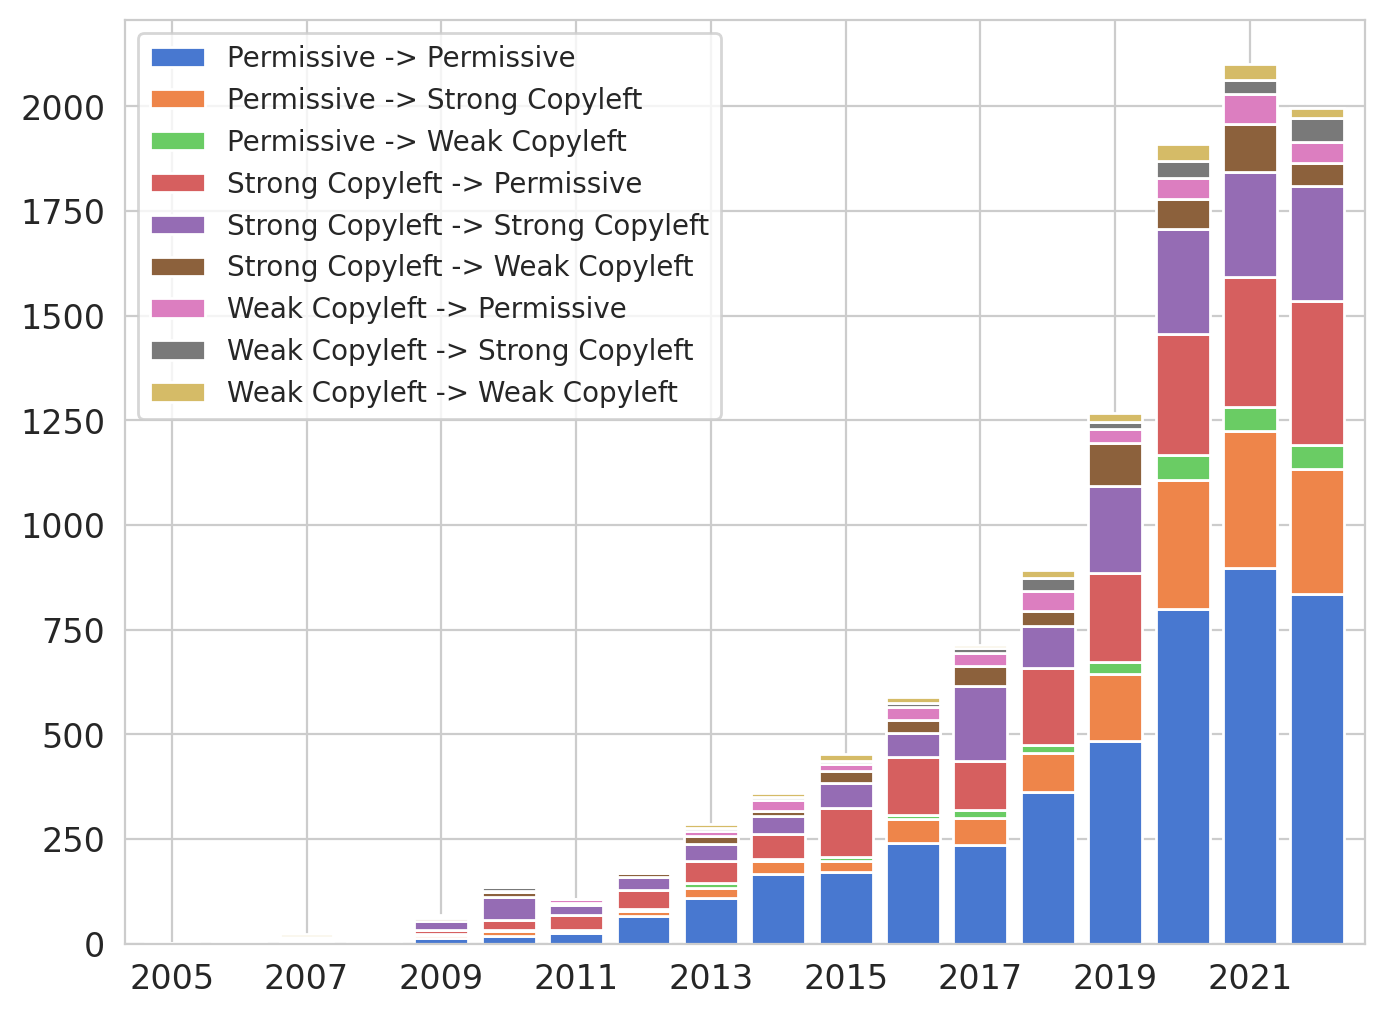

In [69]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(8, 6))
    plot_yearly_freq(ax, license_type_changes, order=lambda x: x[0], palette="muted")
    # fig.autofmt_xdate()

In [70]:
get_freq_table(Counter(x[1] for x in license_perm_changes))

,Type,Count,Percentage
0,Same,6248,56.20%
1,More Permissive,2907,26.15%
2,Less Permissive,1962,17.65%


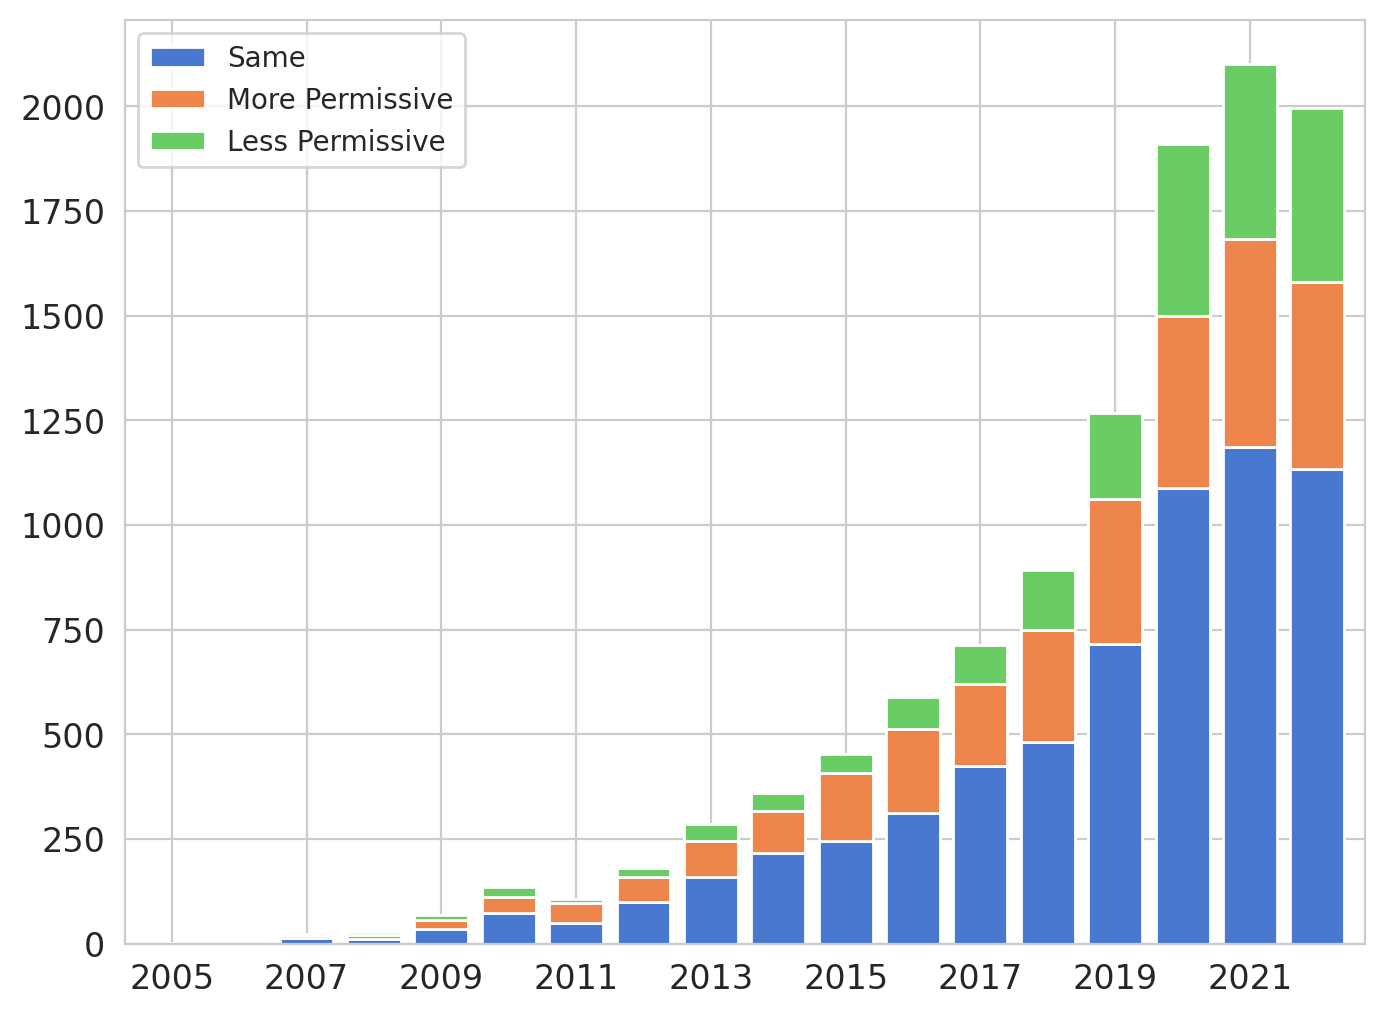

In [71]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(8, 6))
    plot_yearly_freq(ax, license_perm_changes, palette="muted")
    # fig.autofmt_xdate()